In [1]:
# GENERAL IMPORTS

import torch
from mapping.datasets import RLDatasetFormatter
from mapping.models import Discriminator, TransitionModel, LitAutoEncoder

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# READING OF DATASETS

dataset_t_path = 'data/UntrainedPendDataset500.csv'
dataset_s_path = 'data/UntrainedMCDataset5000.csv'
extended_dataset_t_path = 'data/UntrainedPendDataset5000.csv'
super_extended_dataset_t_path = 'data/UntrainedPendDataset50000.csv'

data_formatter_t = RLDatasetFormatter().from_csv(dataset_t_path)
data_formatter_s = RLDatasetFormatter().from_csv(dataset_s_path)
ext_data_formatter_t = RLDatasetFormatter().from_csv(extended_dataset_t_path)
super_ext_data_formatter_t = RLDatasetFormatter().from_csv(super_extended_dataset_t_path)

In [3]:
# TRAINING OF DISCRIMINATOR


def generate_synthetic_dataset(n, s_bound, a_bound):

    fake_s, fake_s1, fake_a = [], [], []

    for r0, r1 in s_bound:
        fake_s.append((r1-r0)*torch.rand((n, 1)) + r0)
    fake_s = torch.cat(fake_s, 1)

    for r0, r1 in a_bound:
        fake_a.append((r1-r0)*torch.rand((n, 1)) + r0)
    fake_a = torch.cat(fake_a, 1)

    for r0, r1 in s_bound:
        fake_s1.append((r1-r0)*torch.rand((n, 1)) + r0)
    fake_s1 = torch.cat(fake_s1, 1)
    fake_r = torch.zeros((n, 1))

    return RLDatasetFormatter([fake_s, fake_a, fake_r, fake_s1]).transition_as_fake()


disc_dataset = data_formatter_t.transition_as_valid()

fake_samples = [
    {
        'count': len(disc_dataset)//2,
        's_bound': [(-1., 1.), (-1.,1.), (-8., 8.)],
        'a_bound': [(-2., -2)]
    },
    {
        'count': len(disc_dataset)//2,
        's_bound': [(-10., 10.), (-10.,10.), (-80., 80.)],
        'a_bound': [(-20., -20.)]
    },
    {
        'count': len(disc_dataset)//2,
        's_bound': [(-100., 100.), (-100.,100.), (-800., 800.)],
        'a_bound': [(-200., -200.)]
    }]

for desc in fake_samples:
    sd = generate_synthetic_dataset(desc['count'], desc['s_bound'], desc['a_bound'])
    disc_dataset = disc_dataset.merge(sd)


D = Discriminator(data_formatter_t.state_size, data_formatter_t.action_size)
D.train_model(disc_dataset, model_dir='/Discriminator', batch_size=20)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs_mc2pend/Discriminator/lightning_logs

  | Name           | Type       | Params
----------------------------------------------
0 | sfc            | Sequential | 8.6 K 
1 | actionfc       | Sequential | 8.4 K 
2 | s1fc           | Sequential | 8.6 K 
3 | model          | Sequential | 24.7 K
4 | loss_criterion | BCELoss    | 0     
----------------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:262: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  "Could not log computational gr

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:156

Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 98.20it/s, loss=4.69e-05, v_num=0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 96.08it/s, loss=4.69e-05, v_num=0]


In [4]:
dataset_t = data_formatter_t.as_transitions()

T = TransitionModel(data_formatter_t.state_size, data_formatter_t.action_size)
T.train_model(dataset_t, model_dir='/T')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs_mc2pend/T/lightning_logs

  | Name           | Type       | Params
----------------------------------------------
0 | loss_criterion | L1Loss     | 0     
1 | statefc        | Sequential | 8.6 K 
2 | actionfc       | Sequential | 8.4 K 
3 | predfc         | Sequential | 16.6 K
----------------------------------------------
33.7 K    Trainable params
0         Non-trainable params
33.7 K    Total params
0.135     Total estimated model params size (MB)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 131.71it/s, loss=0.232, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 114.34it/s, loss=0.232, v_num=0]


In [5]:
D_model_checkpoint = 'lightning_logs/Discriminator/lightning_logs/version_0/checkpoints/epoch=99-step=5700.ckpt'
T_model_checkpoint = 'lightning_logs/T/lightning_logs/version_0/checkpoints/epoch=99-step=2300.ckpt'

#T = TransitionModel.load_from_checkpoint(T_model_checkpoint, s_dim=data_formatter_t.state_size, a_dim=data_formatter_t.action_size)
#D = Discriminator.load_from_checkpoint(D_model_checkpoint, s_dim=data_formatter_t.state_size, a_dim=data_formatter_t.action_size)

source_triplet_size = data_formatter_s.state_size*2+data_formatter_s.action_size
AE = LitAutoEncoder(T, D, dim_s=source_triplet_size)

dataset_s = data_formatter_s.transition_identity()
AE.train_model(dataset_s, batch_size=100, model_dir="/AE")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs_mc2pend/AE/lightning_logs

  | Name    | Type            | Params
--------------------------------------------
0 | D       | Discriminator   | 50.3 K
1 | T       | TransitionModel | 33.7 K
2 | encoder | Sequential      | 839   
3 | decoder | Sequential      | 837   
--------------------------------------------
85.6 K    Trainable params
0         Non-trainable params
85.6 K    Total params
0.343     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 92.65it/s, loss=0.00146, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 90.63it/s, loss=0.00146, v_num=0]


In [6]:
M = AE.encoder
M_inv = AE.decoder

dataset_s = data_formatter_s.transition_identity()

sas, _ = dataset_s[:]
synthetic_data = M(sas)
r_synth = torch.zeros((synthetic_data.shape[0],1))
s_synth,a_synth,s1_synth = torch.split(synthetic_data, [data_formatter_t.state_size, data_formatter_t.action_size, data_formatter_t.state_size],1)
data_formatter_synth = RLDatasetFormatter([s_synth, a_synth, r_synth, s1_synth])

In [7]:
dataset_synth = data_formatter_synth.as_transitions()
dataset_hybrid = data_formatter_t.as_transitions().merge(dataset_synth)
T_hat = TransitionModel(data_formatter_t.state_size, data_formatter_t.action_size)
T_hat.train_model(dataset_hybrid, model_dir='/T_hat')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs_mc2pend/T_hat/lightning_logs

  | Name           | Type       | Params
----------------------------------------------
0 | loss_criterion | L1Loss     | 0     
1 | statefc        | Sequential | 8.6 K 
2 | actionfc       | Sequential | 8.4 K 
3 | predfc         | Sequential | 16.6 K
----------------------------------------------
33.7 K    Trainable params
0         Non-trainable params
33.7 K    Total params
0.135     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 276/276 [00:03<00:00, 91.32it/s, loss=0.0365, v_num=0]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 276/276 [00:03<00:00, 90.37it/s, loss=0.0365, v_num=0]


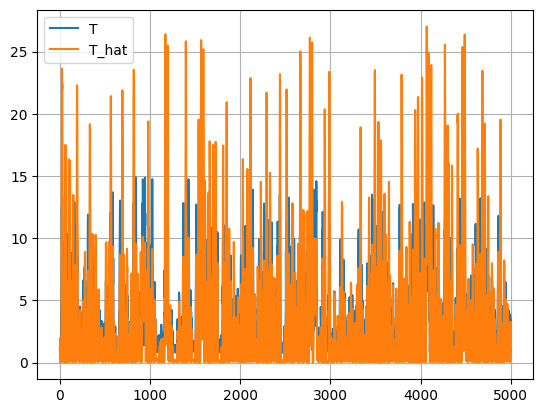

In [8]:
ext_dataset_t = ext_data_formatter_t.as_transitions()

sa, s1 = ext_dataset_t[:]

import matplotlib.pyplot as plt

error = T(sa)-s1
plt.plot(torch.norm(error,dim=1,).detach().numpy())
error = T_hat(sa)-s1
plt.plot(torch.norm(error,dim=1).detach().numpy())

plt.legend(['T', 'T_hat'])
plt.grid()

In [9]:
ext_dataset_t = ext_data_formatter_t.as_transitions()
T_ext = TransitionModel(data_formatter_t.state_size, data_formatter_t.action_size)
T_ext.train_model(ext_dataset_t, model_dir='/T_ext')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./lightning_logs_mc2pend/T_ext/lightning_logs

  | Name           | Type       | Params
----------------------------------------------
0 | loss_criterion | L1Loss     | 0     
1 | statefc        | Sequential | 8.6 K 
2 | actionfc       | Sequential | 8.4 K 
3 | predfc         | Sequential | 16.6 K
----------------------------------------------
33.7 K    Trainable params
0         Non-trainable params
33.7 K    Total params
0.135     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:262: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  "Could not log computational graph to TensorBoard: The `model.example_input_arra

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 45:  96%|█████████▌| 240/250 [00:01<00:00, 148.83it/s, loss=0.0472, v_num=0]

In [ ]:
dataset_synth = data_formatter_synth.as_transitions()
T_synth = TransitionModel(data_formatter_t.state_size, data_formatter_t.action_size)
T_synth.train_model(dataset_synth, model_dir='/T_synth')

In [ ]:
super_ext_dataset_t = super_ext_data_formatter_t.as_transitions()

sa, s1 = super_ext_dataset_t[:]

import matplotlib.pyplot as plt

models = [T,T_ext,T_hat,T_synth]
model_names = ['Trained on 500 target',
               'Trained on 5000 target',
               'Trained on 500 target + 5000 synthetic',
               'Trained on 5000 synthetic']

for m in models:
    error = torch.norm(m(sa) - s1, dim=1).detach().numpy()
    plt.plot(sorted(error, reverse=True ))


plt.legend(model_names)
plt.title('Transition model trained using different datasets')
plt.grid()

In [ ]:

def plot_state_distribution(dataset, name: str, bins: int = 100):
    """
    Plot the distribution of states in a dataset.
    """
    sa,s1 = dataset[:]
    state_size = s1.shape[1]

    # components = [s1[:,i].detach().numpy() for i in range(state_size)]

    components = [[] for _ in range(state_size)]

    for sa, s1 in dataset:
        for i, c in enumerate(s1):
            components[i].append(c.detach().numpy())

    fig, axs = plt.subplots(state_size)

    for i, c in enumerate(components):
        axs[i].hist(c, bins=bins)
        axs[i].set_ylabel(f"Component {i}")
        axs[i].grid()

    fig.suptitle(
        f"{name}\nState Marginal Distributions"
    )  
    plt.show()



In [ ]:
plot_state_distribution(dataset_t, f"MC Dataset ({len(dataset_t)} samples)")
plot_state_distribution(ext_dataset_t, f"MC Dataset ({len(ext_dataset_t)} samples)")
plot_state_distribution(dataset_synth, f"Mapped Dataset PEND2MC ({len(dataset_synth)} samples)")
plot_state_distribution(dataset_hybrid, f"Hybrid Dataset MC500+Mapped5000 ({len(dataset_t) + len(dataset_synth)} samples)")